**Feature-rich Network Analysis**: Analyze the interplay of node/edge attributes w.r.t. the modeled topology. Is it possible to observe relevant multiscale mixing patterns (i.e., using Conformity (https://github.com/GiulioRossetti/conformity) or other node-related measures (https://github.com/piratepeel/MultiscaleMixing) on subpopulations)? Do exist correla- tions, at the node level, between some topological attribute (e.g., clustering, centrality...) and the entropy/purity of the node’s neighborhood attributes?

In [212]:
import networkx as nx
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from conformity import attribute_conformity
import powerlaw
warnings.filterwarnings('ignore')
%matplotlib inline 

In [213]:
df = pd.read_csv('data/edges.csv')#, usecols=[1, 2])

df.tail()

,Unnamed: 0,edge,count,source,target,source_class,target_class
466444,466444,zizu232 fancybeekeeper,1,zizu232,fancybeekeeper,entj,entj
466445,466445,znslattt fatafata12,1,znslattt,fatafata12,entp,entj
466446,466446,zoinks27 ravenpvff,1,zoinks27,ravenpvff,infp,infp
466447,466447,zu_capone kukdraws,1,zu_capone,kukdraws,infj,infj
466448,466448,zuqwaylh Kythoarr,1,zuqwaylh,Kythoarr,istp,enfp


In [214]:
df_class = pd.read_csv('data/author_class.csv', usecols=[1, 3])
df_class.head()

,author,i_or_e
0,cypranius,e
1,kikibiki,e
2,Kbnation,e
3,alistair373,i
4,coolerstuff10,e


In [215]:
flags = df_class.set_index('author')['i_or_e'].to_dict()

In [216]:
Graphtype = nx.MultiGraph()
G = nx.from_pandas_edgelist(df,source = 'source', target = 'target', edge_key='count',create_using=Graphtype)
nx.set_node_attributes(G, flags, "flag")    # add flag to graph

In [217]:
from collections import Counter
node_flags = nx.get_node_attributes(G, "flag")

flag_counts = Counter(node_flags.values())
flag_counts # total number of i and e

Counter({'e': 7810, 'i': 18999})

In [218]:
G.number_of_nodes()

26809

In [219]:
G.nodes()['1Zer0Her0']['flag']

'e'

In [220]:
from scipy.optimize import curve_fit

def power_law_fit(k, a, b):
    return a * k ** b

def degree_correlation_function(G):
    degrees = dict(G.degree())
    knn_sum = {}
    knn_count = {}

    for node in G.nodes():
        k = degrees[node]
        knn = np.mean([degrees[neighbor] for neighbor in G.neighbors(node)])
        
        if k in knn_sum:
            knn_sum[k] += knn
            knn_count[k] += 1
        else:
            knn_sum[k] = knn
            knn_count[k] = 1
    
    # Calculate average neighbor degree for each degree
    knn_avg = {k: knn_sum[k] / knn_count[k] for k in knn_sum}
    
    return knn_avg

def plot_degree_correlation(G):
    knn_original = degree_correlation_function(G)
    
    k_original = np.array(list(knn_original.keys()))
    knn_original_values = np.array(list(knn_original.values()))
    
    # Calculate the mean degree of the original graph for the random prediction
    mean_degree = np.mean([deg for node, deg in G.degree()])

    # Fit with power law
    popt, _ = curve_fit(power_law_fit, k_original, knn_original_values)
    a, b = popt
    
    plt.figure(figsize=(10, 6))
    plt.loglog(k_original, knn_original_values, 'bo', label='Original Graph')
    #plt.axhline(y=mean_degree, color='r', linestyle='-', label='Random Prediction')
    k_fit = np.linspace(min(k_original), max(k_original), 100)
    knn_fit = power_law_fit(k_fit, a, b)
    plt.loglog(k_fit, knn_fit, 'g--', label=f'Power-Law Fit: $k^{{{b:.2f}}}$')
    plt.xlabel('Degree (k)')
    plt.ylabel(r'k$_{nn}$(k))')
    plt.legend()
    plt.title('Degree Correlation')
    plt.grid(True)
    plt.show()

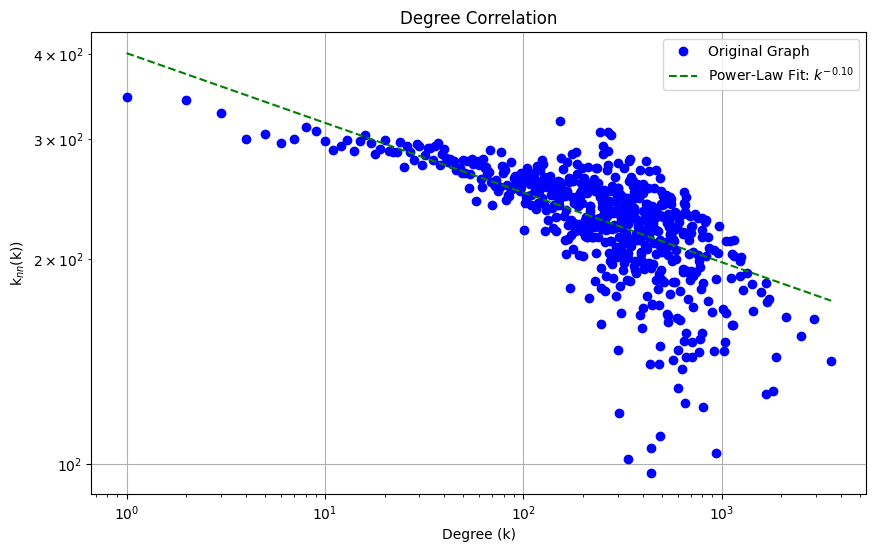

In [221]:
plot_degree_correlation(G)

In [222]:
from conformity import attribute_conformity
alphas = [1., 2.5, 4.]

node_to_conformity = attribute_conformity(G, alphas, ['flag'], profile_size=1)


  0%|          | 3/26809 [00:01<3:18:21,  2.25it/s]


KeyboardInterrupt: 

In [ ]:
node_to_conformity

{'1.0': {'flag': {'--------_--': -0.3056189567545499,
   'Juulsteen': -0.36863449660272896,
   '1Zer0Her0': -0.37589642302088966,
   '5wings4birds': 0.4217433625930807,
   'Ak_707': 0.5218835733026173,
   'AlmightyShrimp': 0.413207177228576,
   'AlunyaColico': -0.40069808728193107,
   'Breakfast-Socks': 0.45667845321757844,
   'Brilliant-Papaya-820': 0.4249217064794837,
   'D1D420': -0.28121113723061225,
   'DefinetlyNotNormal': 0.41547083126291784,
   'ElaborateRuseman': -0.4517818067473325,
   'GrowingToad': -0.4182571501967165,
   'Inkyuun': 0.3769753332898947,
   'KTVX94': 0.46533904706441087,
   'LightBlueOctoBaby': 0.44538318213188693,
   'Lomek': 0.4808489158078204,
   'Morbu': 0.48006582206779574,
   'N0rthWind': 0.43555747661257244,
   'Quess_Iam_Redditor': 0.48291260106868444,
   'SeaSaltSalad': 0.43600107328279575,
   'SlickBlackLimousine': 0.4608155076386572,
   'SpicySlavic': 0.4364938425702704,
   'Verkehrsantrieb': -0.38368105611006365,
   'WritingIvy': 0.484260512014919

In [ ]:
G.degree['washablememe']

9

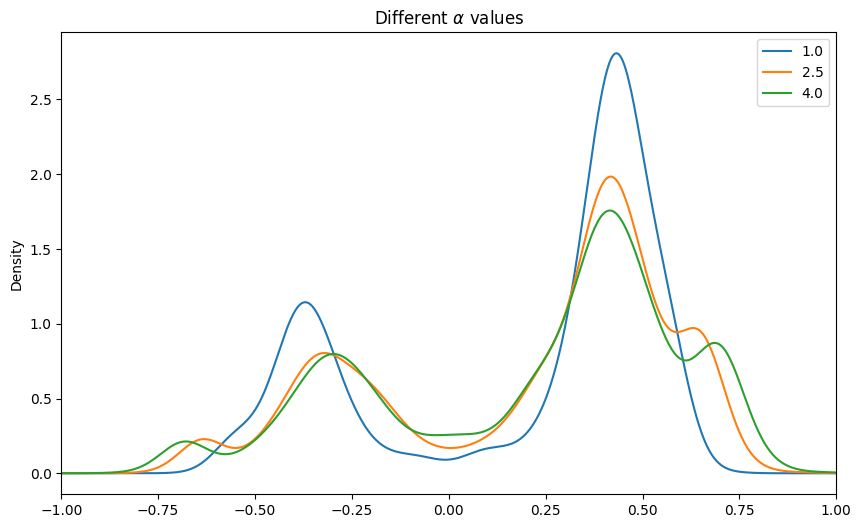

In [ ]:
_, ax = plt.subplots(figsize = (10,6))

for alpha, profiles in node_to_conformity.items():
    for profile, data in profiles.items():
        df = pd.DataFrame(list(data.values()), columns=[alpha])
        df.plot.kde(ax=ax)


plt.title(r'Different $\alpha$ values')
plt.xlim((-1,1))
plt.legend()
plt.show()

In [ ]:
nx.attribute_assortativity_coefficient(G, 'flag')

0.07261677746377017

In [ ]:
# Create the merged dictionary
a='1.0'
K = nx.DiGraph(G)
merged_dict = {key: {'flag': flags[key], 'conformity': node_to_conformity[a]['flag'][key], 'degree': G.degree[key], 'clustering': nx.clustering(K, key)} for key in node_to_conformity[a]['flag']}

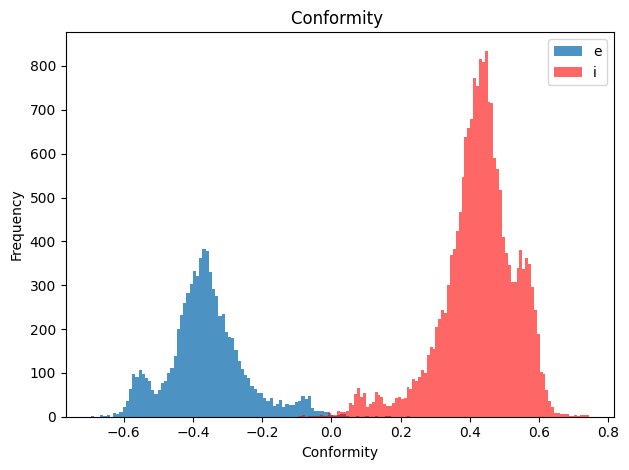

In [ ]:
# Separate the conformity values based on the flag
conformity_e = [info['conformity'] for info in merged_dict.values() if info['flag'] == 'e']
conformity_i = [info['conformity'] for info in merged_dict.values() if info['flag'] == 'i']

# Histogram for 'e' flag
plt.hist(conformity_e, bins=100, label = 'e', alpha = 0.8)
plt.title("Conformity ")
plt.xlabel('Conformity')
plt.ylabel('Frequency')
plt.hist(conformity_i, bins=100, color='red', label ='i', alpha = 0.6)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Create the merged dictionary
a='2.5'
merged_dict = {key: {'flag': flags[key], 'conformity': node_to_conformity[a]['flag'][key], 'degree': G.degree[key], 'clustering': nx.clustering(K, key)} for key in node_to_conformity[a]['flag']}

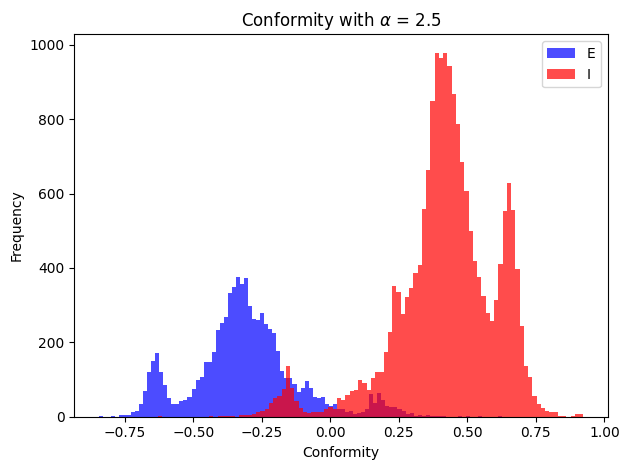

In [ ]:
# Separate the conformity values based on the flag
conformity_e = [info['conformity'] for info in merged_dict.values() if info['flag'] == 'e']
conformity_i = [info['conformity'] for info in merged_dict.values() if info['flag'] == 'i']

# Histogram for 'e' flag
plt.plot(figsize = (10,6))
plt.hist(conformity_e, bins=100, label = 'E', alpha = 0.7, color = 'blue')
plt.title(r"Conformity with $\alpha$ = 2.5")
plt.xlabel('Conformity')
plt.ylabel('Frequency')
plt.hist(conformity_i, bins=100, color='red', label ='I', alpha = 0.7)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Create the merged dictionary
a='4.0'
merged_dict_4 = {key: {'flag': flags[key], 'conformity': node_to_conformity[a]['flag'][key], 'degree': G.degree[key], 'clustering': nx.clustering(K, key)} for key in node_to_conformity[a]['flag']}

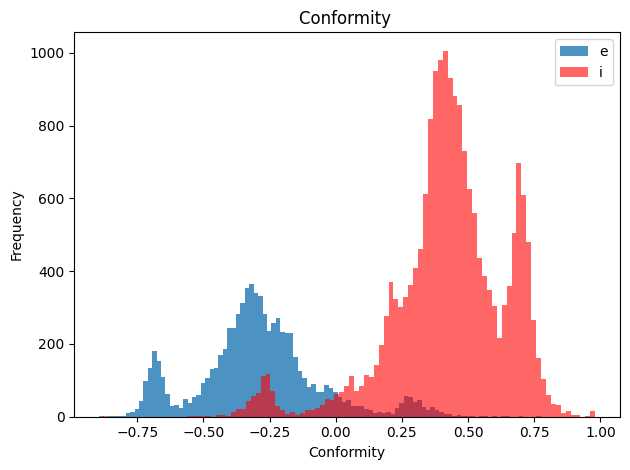

In [ ]:
# Separate the conformity values based on the flag
conformity_e = [info['conformity'] for info in merged_dict_4.values() if info['flag'] == 'e']
conformity_i = [info['conformity'] for info in merged_dict_4.values() if info['flag'] == 'i']

# Histogram for 'e' flag
plt.hist(conformity_e, bins=100, label = 'e', alpha = 0.8)
plt.title("Conformity ")
plt.xlabel('Conformity')
plt.ylabel('Frequency')
plt.hist(conformity_i, bins=100, color='red', label ='i', alpha = 0.6)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

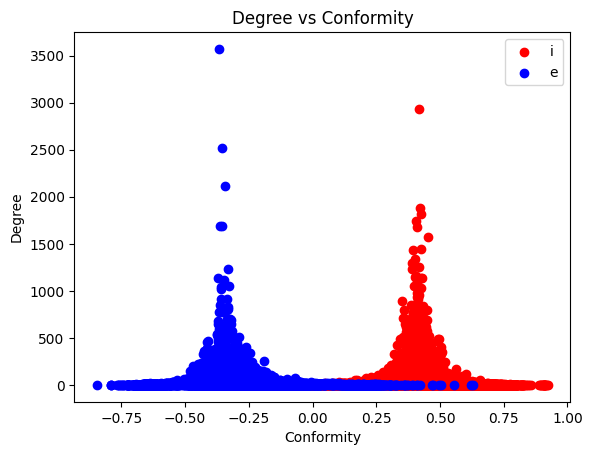

In [ ]:
degrees_i = [info['degree'] for info in merged_dict.values() if info['flag'] == 'i']
conformities_i = [info['conformity'] for info in merged_dict.values() if info['flag'] == 'i']

degrees_e = [info['degree'] for info in merged_dict.values() if info['flag'] == 'e']
conformities_e = [info['conformity'] for info in merged_dict.values() if info['flag'] == 'e']

plt.scatter( np.array(conformities_i),degrees_i, color='red', label="i")
plt.scatter( np.array(conformities_e), degrees_e, color='blue', label="e")
plt.title('Degree vs Conformity')
plt.ylabel('Degree')
plt.xlabel('Conformity')
#plt.loglog()
plt.legend()
plt.show()

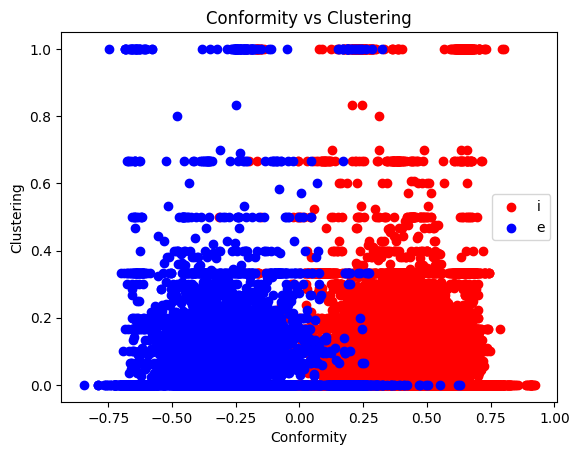

In [ ]:
clustering_i = [info['clustering'] for info in merged_dict.values() if info['flag'] == 'i']
clustering_e = [info['clustering'] for info in merged_dict.values() if info['flag'] == 'e']

plt.scatter( conformities_i, clustering_i, color='red', label="i")
plt.scatter(conformities_e, clustering_e, color='blue', label="e")
plt.title('Conformity vs Clustering')
plt.ylabel('Clustering')
plt.xlabel('Conformity')
#plt.loglog()
plt.legend()
plt.show()

In [ ]:
from collections import Counter
from scipy.stats import entropy

def calculate_entropy_purity(neighbors):
    attributes = [G.nodes[neighbor]['flag'] for neighbor in neighbors]
    count = Counter(attributes)
    total = sum(count.values())
    probabilities = [count[attr] / total for attr in count]
    ent = entropy(probabilities)
    purity = max(probabilities)
    return ent, purity

entropy_purity = {}
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    if neighbors:
        ent, pur = calculate_entropy_purity(neighbors)
        entropy_purity[node] = {'entropy': ent, 'purity': pur}
    else:
        entropy_purity[node] = {'entropy': 0, 'purity': 1}

In [ ]:
clustering = nx.clustering(K)
centrality = nx.degree_centrality(G)


In [ ]:
avg_neig_degree = nx.average_neighbor_degree(G)

In [ ]:
data = []
for node in G.nodes():
    data.append({
        'node': node,
        'flag':G.nodes[node]['flag'],
        'clustering': clustering[node],
        'degree': centrality[node],
        'avg neigh degree': avg_neig_degree[node],
        'conformity': node_to_conformity['1.0']['flag'][node],
        'entropy': entropy_purity[node]['entropy'],
        'purity': entropy_purity[node]['purity']
    })

df = pd.DataFrame(data)

# Calculate correlations
correlation_matrix = df[['clustering', 'degree','avg neigh degree', 'conformity', 'entropy', 'purity']].corr('spearman')
print(correlation_matrix)

                  clustering    degree  avg neigh degree  conformity  \
clustering          1.000000  0.339041          0.394724   -0.070335   
degree              0.339041  1.000000         -0.005816   -0.072473   
avg neigh degree    0.394724 -0.005816          1.000000   -0.028905   
conformity         -0.070335 -0.072473         -0.028905    1.000000   
entropy             0.225593  0.315956          0.065341   -0.483249   
purity             -0.077983 -0.098998         -0.041784    0.900545   

                   entropy    purity  
clustering        0.225593 -0.077983  
degree            0.315956 -0.098998  
avg neigh degree  0.065341 -0.041784  
conformity       -0.483249  0.900545  
entropy           1.000000 -0.522642  
purity           -0.522642  1.000000  


<AxesSubplot:>

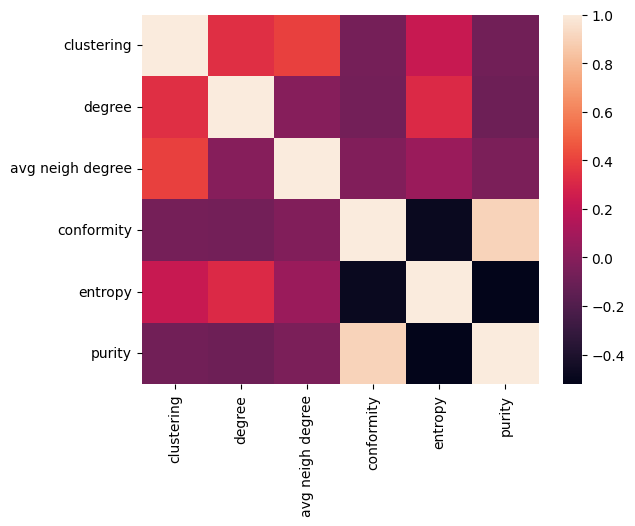

In [ ]:
import seaborn 
seaborn.heatmap(correlation_matrix)

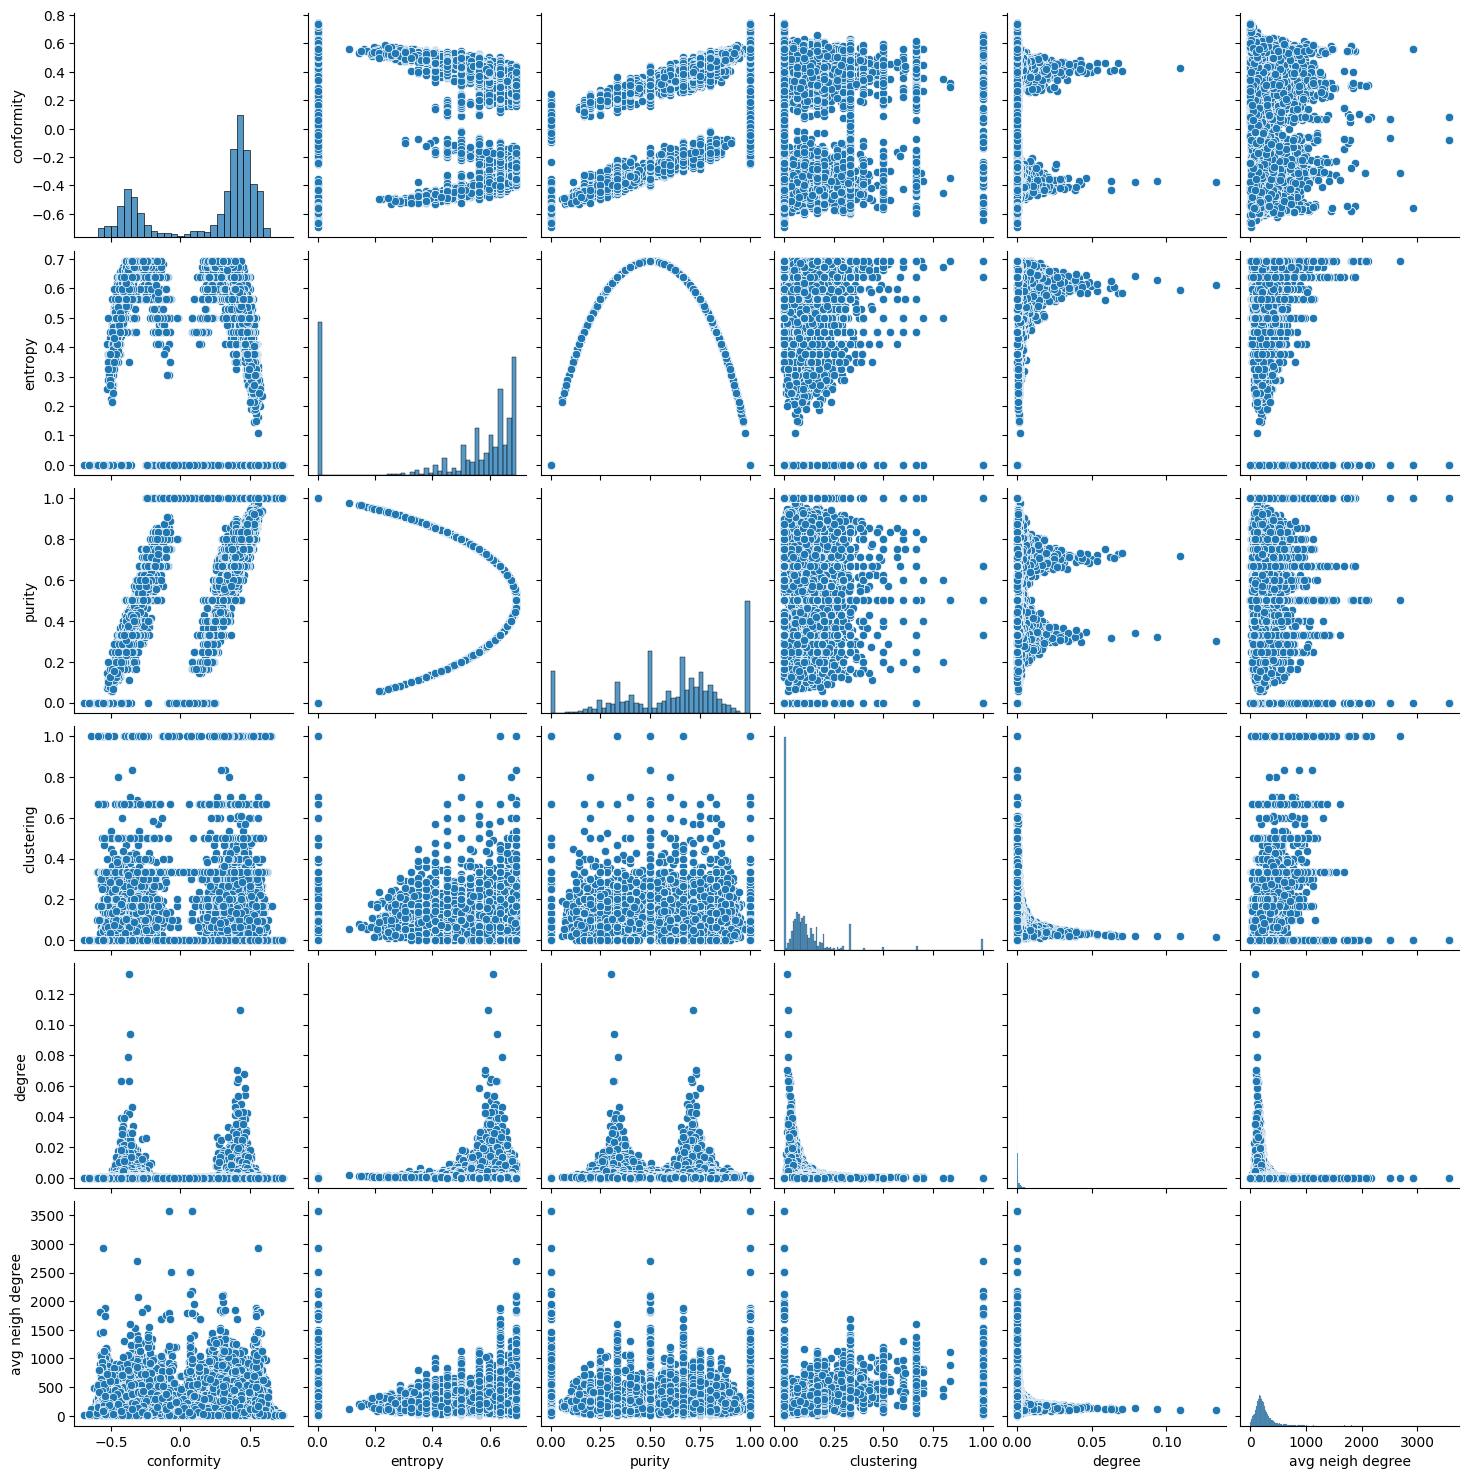

In [ ]:
df = df[['conformity', 'entropy', 'purity', 'clustering', 'degree','avg neigh degree']]
seaborn.pairplot(df)

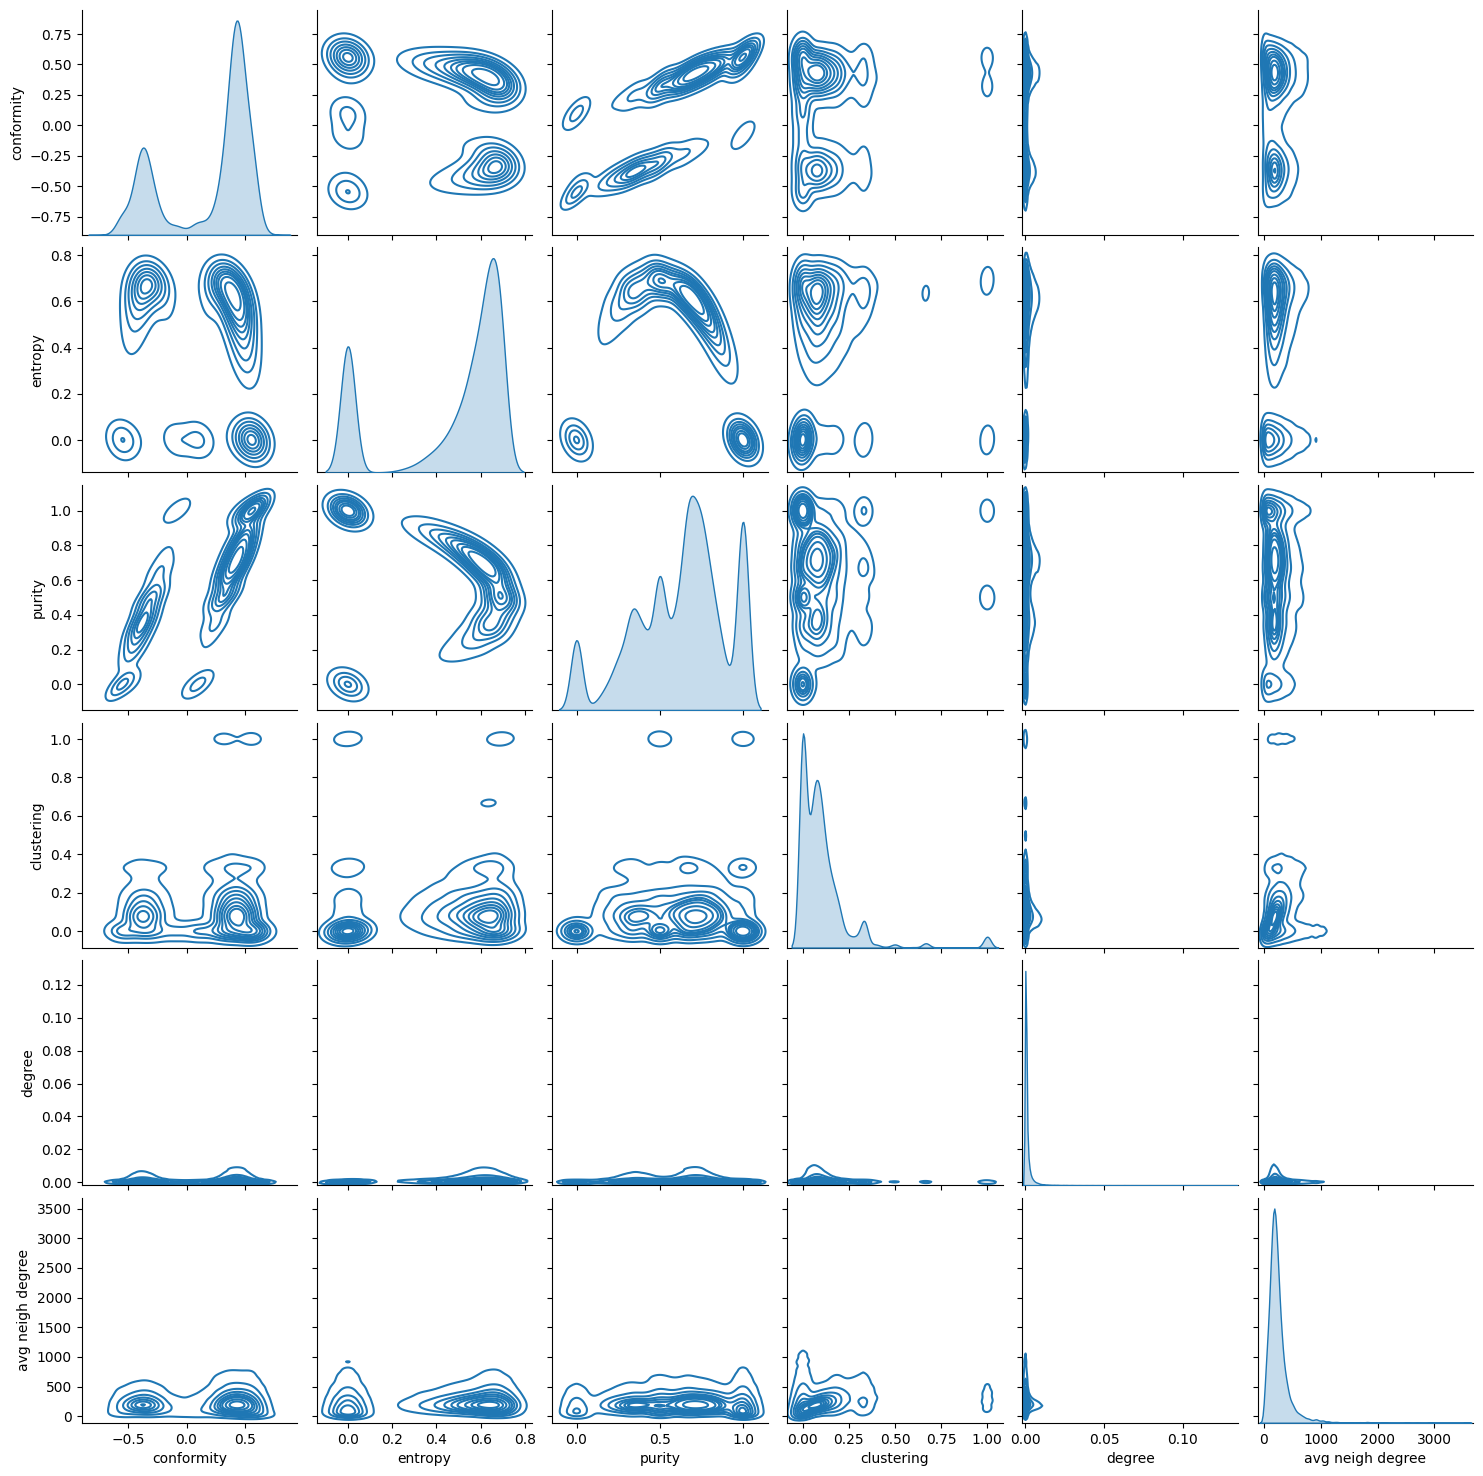

In [ ]:
seaborn.pairplot(df, kind="kde")

In [ ]:
from scipy.stats import spearmanr, kendalltau
spearman_corr, _ = spearmanr(df, axis=0)
kendall_corr, _ = kendalltau(df['entropy'], df['degree'])
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall Tau Correlation: {kendall_corr}")

Spearman Correlation: [[ 1.         -0.48324907  0.90054498 -0.07033479 -0.07247289 -0.02890477]
 [-0.48324907  1.         -0.52264172  0.22559274  0.31595588  0.06534127]
 [ 0.90054498 -0.52264172  1.         -0.07798319 -0.09899752 -0.04178374]
 [-0.07033479  0.22559274 -0.07798319  1.          0.33904082  0.39472439]
 [-0.07247289  0.31595588 -0.09899752  0.33904082  1.         -0.00581589]
 [-0.02890477  0.06534127 -0.04178374  0.39472439 -0.00581589  1.        ]]
Kendall Tau Correlation: 0.21896546270923894


<AxesSubplot:>

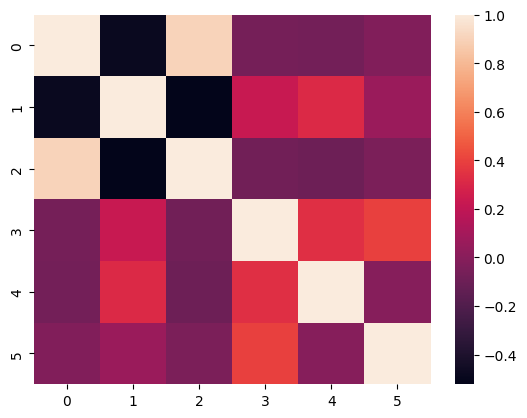

In [ ]:
seaborn.heatmap(spearman_corr)

pairplot = seaborn.pairplot(df)
a = ((0,0), (0,1), (0,2), (0,3), (0,4), (0,5), 
     (1, 0), (1,1), (1,2), (1,3), (1,4), (1,5),
     (2, 0), (2,1), (2,2), (2,3), (2,4), (2,5),
     (3,3), (3,4), (3,5), (4,4), (4,5), (5,5))
for i, j in a:
    print(i, j)
    pairplot.axes[i, j].set_visible(False)

# Adjust layout
plt.subplots_adjust(hspace=0.1, wspace=0.1)

# Display the plot
plt.show()

In [ ]:
data_dict = {}
for item in data:
   name = item['node']
   data_dict[name] = item

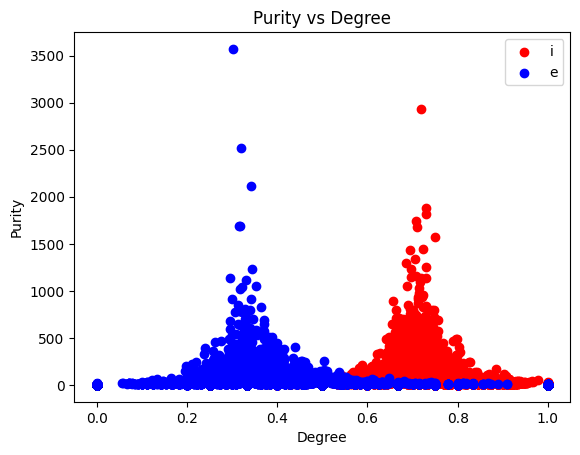

In [ ]:
purity_i = [info['purity'] for info in data_dict.values() if info['flag'] == 'i']
purity_e = [info['purity'] for info in data_dict.values() if info['flag'] == 'e']

plt.scatter(purity_i, degrees_i, color='red', label="i")
plt.scatter(purity_e,degrees_e, color='blue', label="e")
plt.title('Purity vs Degree')
plt.xlabel('Degree')
plt.ylabel('Purity')
#plt.loglog()
plt.legend()
plt.show()

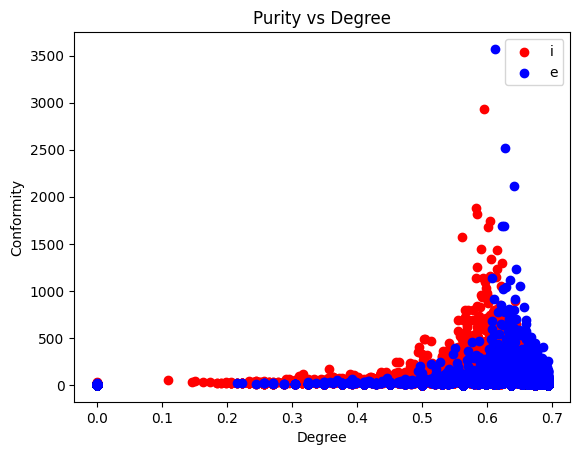

In [ ]:
entropy_i = [info['entropy'] for info in data_dict.values() if info['flag'] == 'i']
entropy_e = [info['entropy'] for info in data_dict.values() if info['flag'] == 'e']

plt.scatter(entropy_i, degrees_i, color='red', label="i")
plt.scatter(entropy_e,degrees_e, color='blue', label="e")
plt.title('Purity vs Degree')
plt.xlabel('Degree')
plt.ylabel('Conformity')
#plt.loglog()
plt.legend()
plt.show()